# 4 Ways to Quantify Fat Tails

Code authored by: Shaw Talebi <br>
Blog link: coming soon!

### import modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import powerlaw # doc: https://pythonhosted.org/powerlaw/
from scipy.stats import kurtosis

### load data

In [2]:
filename_list = ['medium-followers', 'YT-earnings', 'LI-impressions']

df_dict = {}

for filename in filename_list:
    df = pd.read_csv('data/'+filename+'.csv')
    df = df.set_index(df.columns[0]) # set index
    df_dict[filename] = df

#### look at data

In [3]:
def plot_histograms(data, title, var_name):
    """
        Function to plot histogram and log-histogram of input array
    """
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.hist(data)
    plt.title(title)
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(np.log10(data))
    plt.title(title + " - Log Plot")
    plt.xlabel("log(" + var_name + ")")
    plt.ylabel("Frequency")
    plt.grid()

Top 5 Records by Percentage
period_start
2023-10-01    0.422913
2023-09-01    0.180266
2023-08-01    0.040560
2023-07-01    0.039137
2023-06-01    0.031072
Name: followers_gained, dtype: float64

Top 5 Records by Percentage
Video title
How to Create a Custom Email Signature in Gmail (2023)           0.215000
Fine-tuning Large Language Models (LLMs) | w/ Example Code       0.213472
How to Make a Data Science Portfolio With GitHub Pages (2023)    0.169913
How to Build an LLM from Scratch | An Overview                   0.093017
Topological Data Analysis (TDA) | An introduction                0.025730
Name: Estimated revenue (USD), dtype: float64

Top 5 Records by Percentage
Date
7/14/2023    0.053376
7/24/2023    0.040778
8/28/2023    0.029161
9/12/2023    0.026821
4/22/2023    0.021268
Name: Impressions, dtype: float64



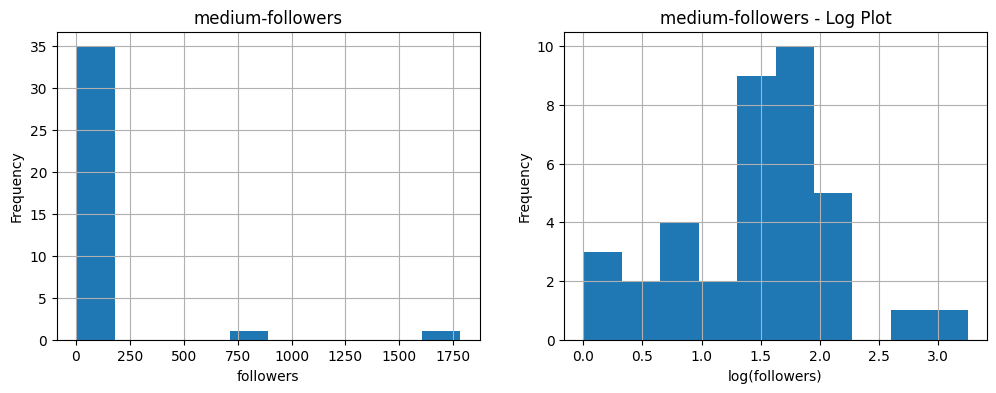

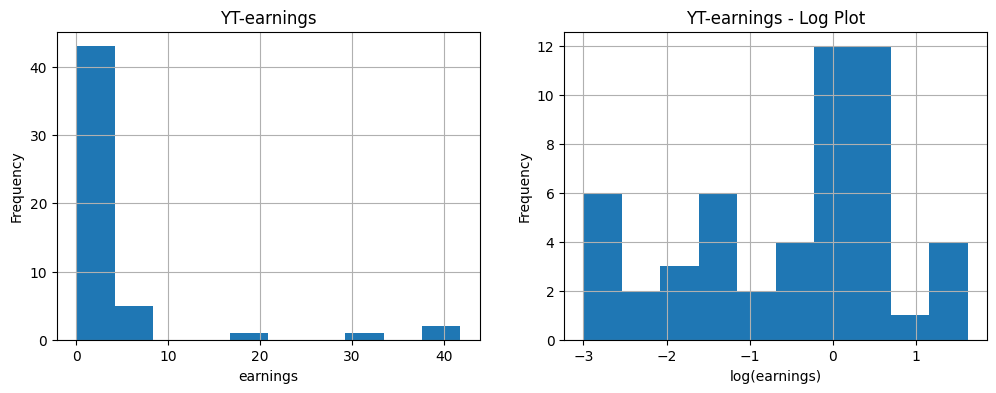

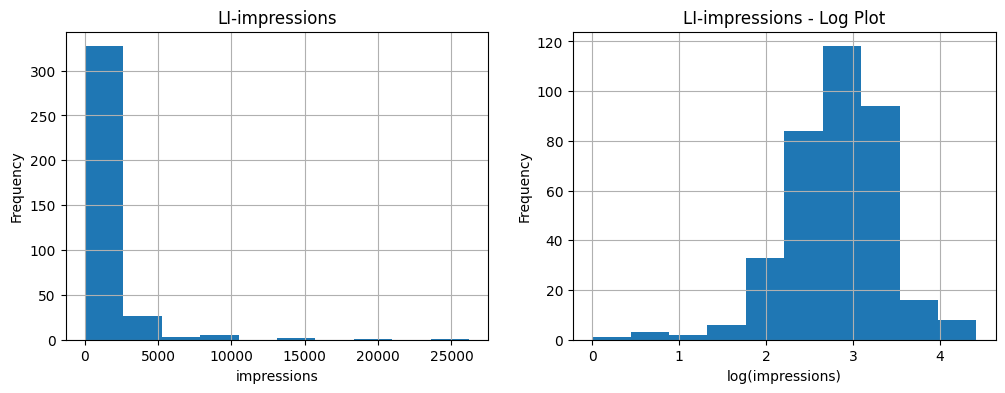

In [4]:
for filename in filename_list:
    df = df_dict[filename]
    
    # plot histograms
    plot_histograms(df.iloc[:,0][df.iloc[:,0]>0], filename, filename.split('-')[1])
    
    # print top 5 records
    print("Top 5 Records by Percentage")
    print((df.iloc[:,0]/df.iloc[:,0].sum()).sort_values(ascending=False)[:5])
    print("")

### Heuristic 1: Power Law Tail Index

In [5]:
for filename in filename_list:
    df = df_dict[filename]

    # perform Power Law fit
    results = powerlaw.Fit(df.iloc[:,0])
    # results = powerlaw.Fit(df.iloc[:,0], xmin=df.iloc[:,0].min()) # uncomment to force fit to use all data

    # print results
    print("")
    print(filename)
    print("-"*len(filename))
    print("Power Law Fit")
    print("a = " + str(results.power_law.alpha-1))
    print("xmin = " + str(results.power_law.xmin))
    print("")

Calculating best minimal value for power law fit
xmin progress: 96%
medium-followers
----------------
Power Law Fit
a = 0.8388047096788038
xmin = 21.0

Calculating best minimal value for power law fit
xmin progress: 97%
YT-earnings
-----------
Power Law Fit
a = 0.9006867224269297
xmin = 1.162

Calculating best minimal value for power law fit
xmin progress: 99%
LI-impressions
--------------
Power Law Fit
a = 1.4734011749061655
xmin = 1146.0



Values less than or equal to 0 in data. Throwing out 0 or negative values


### Heuristic 2: Kurtosis

In [6]:
for filename in filename_list:
    df = df_dict[filename]

    # print results
    print(filename)
    print("-"*len(filename))
    print("kurtosis = " + str(kurtosis(df.iloc[:,0], fisher=True)))
    print("")


medium-followers
----------------
kurtosis = 21.962486511657204

YT-earnings
-----------
kurtosis = 11.396525622056606

LI-impressions
--------------
kurtosis = 46.193797161842674



### Heuristic 3: Log Normal Sigma

In [7]:
for filename in filename_list:
    df = df_dict[filename]

    # perform Power Law fit
    results = powerlaw.Fit(df.iloc[:,0])

    # print results
    print("")
    print(filename)
    print("-"*len(filename))
    print("Log Normal Fit")
    print("mu = " + str(results.lognormal.mu))
    print("sigma = " + str(results.lognormal.sigma))
    print("")

Calculating best minimal value for power law fit
xmin progress: 96%
medium-followers
----------------
Log Normal Fit
mu = 0.14960923130348636
sigma = 2.435242723918806

Calculating best minimal value for power law fit
xmin progress: 97%
YT-earnings
-----------
Log Normal Fit
mu = -24.73920867627741
sigma = 5.478478824764387

Calculating best minimal value for power law fit
xmin progress: 99%
LI-impressions
--------------
Log Normal Fit
mu = 0.345723203829155
sigma = 2.3258753387732964



Values less than or equal to 0 in data. Throwing out 0 or negative values


### Heuristic 4: Taleb's Kappa Metric

ref: https://arxiv.org/abs/1802.05495

In [8]:
def mean_abs_deviation(S):
    """
        Computation of mean absolute deviation of an input sample S
    """
    
    M = np.mean(np.abs(S - np.mean(S)))

    return M

In [9]:
def generate_n_sample(X,n):
    """
        Function to generate n random samples of size len(X) from an array X
    """

    # initialize sample
    S_n=0
    
    for i in range(n):
        
        # ramdomly sample len(X) observations from X and add it to the sample
        S_n = S_n + X[np.random.randint(len(X), size=int(np.round(len(X))))]
    
    return S_n

In [10]:
def kappa(X,n):
    """
        Taleb's kappa metric from n0=1 as described here: https://arxiv.org/abs/1802.05495

        Note: K_1n = kappa(1,n) = 2 - ((log(n)-log(1))/log(M_n/M_1)), where M_n denotes the mean absolute deviation of the sum of n random samples
    """

    S_1 = X
    S_n = generate_n_sample(X,n)
    
    M_1 = mean_abs_deviation(S_1)
    M_n = mean_abs_deviation(S_n)
    
    K_1n = 2 - (np.log(n)/np.log(M_n/M_1))

    return K_1n

In [11]:
for filename in filename_list:
    df = df_dict[filename]

    # print results
    print(filename)
    print("-"*len(filename))
    print("kappa_1n = " + str(kappa(df.iloc[:,0].to_numpy(), 100)))
    print("")

medium-followers
----------------
kappa_1n = 0.2546410061529336

YT-earnings
-----------
kappa_1n = 0.3524659512139001

LI-impressions
--------------
kappa_1n = 0.3249569135261603



#### compute mean k(1,30) of running calculation 1000X

In [12]:
N = 1_000

kappa_dict = {}

for filename in filename_list:
    df = df_dict[filename]

    kappa_list = []
    for i in range(N):
        kappa_list.append(kappa(df.iloc[:,0].to_numpy(), 100))

    
    kappa_dict[filename] = np.array(kappa_list)

    print(filename)
    print("-"*len(filename))
    print("mean kappa_1n = " + str(np.mean(kappa_dict[filename])))
    print("")

medium-followers
----------------
mean kappa_1n = 0.40731835098659863

YT-earnings
-----------
mean kappa_1n = 0.3106132028016938

LI-impressions
--------------
mean kappa_1n = 0.3421908055994824



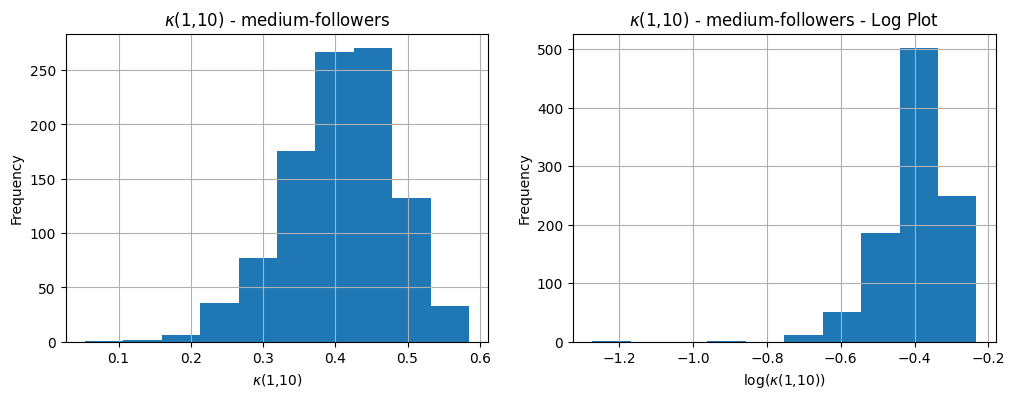

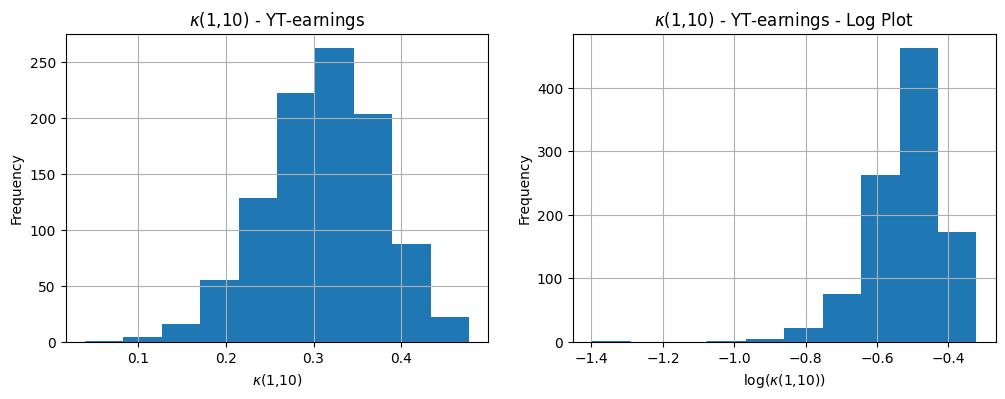

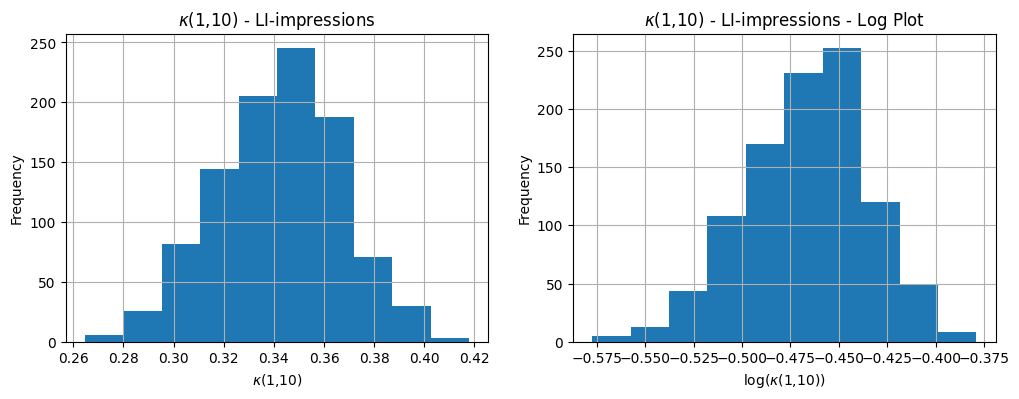

In [13]:
for filename in filename_list:
    plot_histograms(kappa_dict[filename], '$\kappa$(1,10) - ' + filename, '$\kappa$(1,10)')